<a href="https://colab.research.google.com/github/Sayandeepmaity/gseep/blob/main/Building_footprint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
!pip install tensorflow geopandas rasterio matplotlib shapely opencv-python pillow

In [32]:
from google.colab import drive
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.features import geometry_mask
import geopandas as gpd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
import os
import cv2
from sklearn.model_selection import train_test_split

In [23]:
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
def load_image(file_path):
    with rasterio.open(file_path) as src:
        img = src.read([1, 2, 3])
        img = np.transpose(img, (1, 2, 0))
        return img

In [34]:
def load_shapefile(file_path):
    return gpd.read_file(file_path)

In [35]:
def geojson_to_mask(geometries, img_shape, transform):
    masks = np.zeros(img_shape[:2], dtype=np.uint8)
    for geometry in geometries:
        mask = geometry_mask([geometry], transform=transform, invert=True, out_shape=img_shape[:2])
        masks = np.logical_or(masks, mask.astype(np.uint8))
    return masks

In [36]:
def create_masks_for_images(image_files, shapefiles):
    masks = {}
    for key, img_file in image_files.items():
        with rasterio.open(img_file) as src:
            transform = src.transform
            img_shape = src.shape
            masks[key] = geojson_to_mask(shapefiles[key].geometry, img_shape, transform)
    return masks


In [37]:
def augment_images(image, mask):
    datagen = ImageDataGenerator(
        rotation_range=90,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True
    )
    image = image[np.newaxis, ...]
    mask = mask[np.newaxis, ..., np.newaxis]
    it = datagen.flow(image, mask, batch_size=1)
    augmented_image, augmented_mask = it.next()
    return augmented_image.squeeze(), augmented_mask.squeeze()

In [38]:
def save_image(image, file_path):
    image = (image * 255).astype(np.uint8)
    plt.imsave(file_path, image)

In [39]:
def display_and_save_augmented(image_files, masks):
    plt.figure(figsize=(15, 10))
    for i, key in enumerate(image_files.keys()):
        if key not in masks:
            print(f"Warning: No mask found for {key}")
            continue
        image = load_image(image_files[key])
        aug_image, aug_mask = augment_images(image, masks[key])
        base_path = os.path.dirname(image_files[key])
        aug_image_path = os.path.join(base_path, f'augmented_{key}_image.png')
        aug_mask_path = os.path.join(base_path, f'augmented_{key}_mask.png')
        save_image(aug_image, aug_image_path)
        save_image(aug_mask, aug_mask_path)
        print(f"Augmented image saved to: {aug_image_path}")
        print(f"Augmented mask saved to: {aug_mask_path}")
        plt.subplot(len(image_files), 2, 2*i+1)
        plt.imshow(aug_image)
        plt.title(f'Augmented Image - {key}')
        plt.axis('off')
        plt.subplot(len(image_files), 2, 2*i+2)
        plt.imshow(aug_mask, cmap='gray')
        plt.title(f'Augmented Mask - {key}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [48]:
dataset_path = '/content/drive/My Drive/dataset/'


image_files = {
    'anganbadi': dataset_path + 'anganbadi.tif',
    'courtyard': dataset_path + 'courtyard.tif',
    'nkdance': dataset_path + 'nkdance.tif'
}


shapefiles = {
    'anganbadi': load_shapefile(dataset_path + 'anganbadi.shp'),
    'courtyard': load_shapefile(dataset_path + 'courtyard.shp'),
    'nkdance': load_shapefile(dataset_path + 'nkdance.shp')
}

In [48]:

masks = create_masks_for_images(image_files, shapefiles)


display_and_save_augmented(image_files, masks)


def load_images_and_masks(image_folder_path, mask_folder_path, image_size=(256, 256)):
    image_files = [f for f in os.listdir(image_folder_path) if f.endswith('_image.png')]
    mask_files = [f for f in os.listdir(mask_folder_path) if f.endswith('_mask.png')]
    images = []
    masks = []
    for image_file in image_files:
        prefix = image_file.replace('_image.png', '')
        corresponding_mask = f"{prefix}_mask.png"
        if corresponding_mask in mask_files:
            img = cv2.imread(os.path.join(image_folder_path, image_file))
            mask = cv2.imread(os.path.join(mask_folder_path, corresponding_mask), cv2.IMREAD_GRAYSCALE)
            if img is not None and mask is not None:
                img = cv2.resize(img, image_size)
                mask = cv2.resize(mask, image_size)
                images.append(img)
                masks.append(mask)
    return np.array(images), np.array(masks)


image_folder_path = '/content/drive/My Drive/dataset/'
mask_folder_path = '/content/drive/My Drive/dataset/'

In [48]:

images, masks = load_images_and_masks(image_folder_path, mask_folder_path)


images = images / 255.0


masks = (masks > 0).astype(np.uint8)

X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)


In [48]:

def unet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = concatenate([up6, conv4], axis=-1)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)
    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = concatenate([up7, conv3], axis=-1)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)
    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = concatenate([up8, conv2], axis=-1)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)
    up9 = UpSampling2D(size=(2, 2))(conv8)
    up9 = concatenate([up9, conv1], axis=-1)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)
    model = Model(inputs=[inputs], outputs=[outputs])
    return model


model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)


model.save('/content/drive/My Drive/dataset/unet_model.h5')


In [48]:

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Preprocessed image shape: (1, 256, 256, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted mask shape: (256, 256)
Predicted mask unique values: [1.]
Final mask shape: (697, 1250)
Final mask unique values: [1]


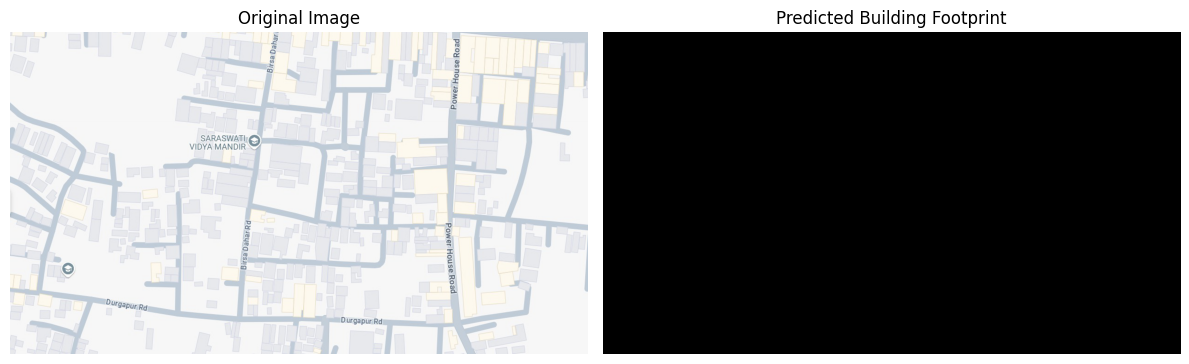

In [48]:

import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import rasterio


model_path = '/content/drive/My Drive/dataset/unet_model.h5'
model = tf.keras.models.load_model(model_path)


def preprocess_image(image_path, target_size=(256, 256)):
    with rasterio.open(image_path) as src:
        img = src.read([1, 2, 3])
        img = np.transpose(img, (1, 2, 0))
        img_resized = cv2.resize(img, target_size)
        img_normalized = img_resized / 255.0
    return img, img_normalized[np.newaxis, ...]


def postprocess_mask(predicted_mask, original_size):
    predicted_mask_resized = cv2.resize(predicted_mask, (original_size[1], original_size[0]))
    return (predicted_mask_resized > 0.5).astype(np.uint8)


def predict_building_footprint(image_path):
    original_image, preprocessed_image = preprocess_image(image_path)
    print("Preprocessed image shape:", preprocessed_image.shape)

    predicted_mask = model.predict(preprocessed_image)[0, :, :, 0]
    print("Predicted mask shape:", predicted_mask.shape)
    print("Predicted mask unique values:", np.unique(predicted_mask))

    original_size = original_image.shape[:2]
    final_mask = postprocess_mask(predicted_mask, original_size)
    print("Final mask shape:", final_mask.shape)
    print("Final mask unique values:", np.unique(final_mask))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(final_mask, cmap='gray')
    plt.title('Predicted Building Footprint')
    plt.axis('off')
    plt.tight_layout()
    plt.show()


satellite_image_path = '/content/drive/My Drive/dataset/testimage.jpg'


predict_building_footprint(satellite_image_path)
